# Assignment: Basic Web Scrapping and more...

Fill in your name here.

In [1]:
name = 'Nesterov Artyom'
if name == '':
    raise NotImplementedError('Put your name')

You will receive points for:
- implementing the given tasks.
- using good practices such as OOP in some cases, or decorators.
- good code structure on the last task.
- handling edge cases and exceptions.
- comprehensive unit tests (by using any of the libraries seen. I recommend `unittest`).

We will need the following libraries, but of course you can add the libraries you prefer.

In [57]:
for _ in range(2):
    try:
        from bs4 import BeautifulSoup
        import requests 
        import unittest
        import networkx as nx
        from urllib.parse import urljoin
        from functools import wraps
    except ImportError:
        ! pip install beautifulsoup4
        ! pip install requests
        ! pip install unittest2
        ! pip install networkx
    else:
        break

## Task 1

The following function receives a URL, and tries to fetch all the links on it, and returns a list with all those links.

1. Modify the function so that it returns the expected links.

2. Be sure to do unit testing to check that the behaviour of the function is the one we expect.

3. Consider edge cases (for example, what if the given URL is not a valid URL).

In [26]:
def get_all_links(url: str):
    """
    Get all the links in the webpage at the given URL

    :param url: A string that is the URL of the webpage where we need to find the links
    :return: A list with all the links of the given webpage
    """
    try:
        response = requests.get(url, timeout=1)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error fetching the URL: {e}")
        return []

    soup = BeautifulSoup(response.text, 'html.parser')
    links = [urljoin(url, a.get('href')) for a in soup.find_all('a', href=True)]
    return links

In [40]:
# Unit tests
class TestGetAllLinks(unittest.TestCase):

    def test_valid_url(self):
        url = 'https://education.yandex.ru/handbook/python/article/intro'
        links = get_all_links(url)
        assertLinks = ['https://yandex.ru/support/common/browsers-settings/browsers-java-js-settings.html','https://www.ya.ru']
        for asLink in assertLinks:
            self.assertIn(asLink, links)

    def test_invalid_url(self):
        url = 'http://invalid-url.com'
        links = get_all_links(url)
        self.assertEqual(links, [])

    def test_edge_case_empty_url(self):
        url = ''
        links = get_all_links(url)
        self.assertEqual(links, [])


unittest.main(argv=[''], exit=False)

.

Error fetching the URL: Invalid URL '': No scheme supplied. Perhaps you meant https://?


.

Error fetching the URL: HTTPConnectionPool(host='ww25.invalid-url.com', port=80): Max retries exceeded with url: /?subid1=20250214-0352-27ca-b2e1-6f8990c0df64 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x125035bf0>, 'Connection to ww25.invalid-url.com timed out. (connect timeout=1)'))


.
----------------------------------------------------------------------
Ran 3 tests in 2.716s

OK


In [20]:
get_all_links('https://education.yandex.ru/handbook/python/article/intro')[:10]

['https://www.ya.ru',
 'https://yandex.ru/support/smart-captcha/problems.html?form-unique_key=6052946581187879173',
 'https://yandex.ru/support/common/browsers-settings/browsers-java-js-settings.html',
 'https://cloud.yandex.ru/services/smartcaptcha?utm_source=captcha&utm_medium=chbx&utm_campaign=security',
 'https://yandex.ru/support/smart-captcha/problems.html?form-unique_key=6052946581187879173']

## Task 2

Create a generator (`get_neighbor_pages`) that receives a URL, but instead of returning a list with all the links in that page, it should go to those links, and  **yield** their html content.

Remember to add unit tests.

In [33]:
def get_neighbor_pages(url: str):
    """
    Go through the links in the webpage at the given URL
    and yield the HTML content of each of them

    :param url: A string that is the URL of the webpage
    """
    links = get_all_links(url)
    for link in links:
        try:
            response = requests.get(link, timeout=10)
            response.raise_for_status()
            yield response.text
        except requests.RequestException as e:
            print(f"Error fetching the URL: {e}")


In [50]:
# Unit tests
class TestGetNeighborPages(unittest.TestCase):

    def test_valid_url(self):
        url = 'https://education.yandex.ru/handbook/python/article/intro'
        pages = list(get_neighbor_pages(url))
        self.assertGreater(len(pages), 0)

    def test_invalid_url(self):
        url = 'http://invalid-url.com'
        pages = list(get_neighbor_pages(url))
        self.assertEqual(len(pages), 0)

    def test_edge_case_empty_url(self):
        url = ''
        pages = list(get_neighbor_pages(url))
        self.assertEqual(len(pages), 0)


unittest.main(argv=[''], exit=False)

Error fetching the URL: 404 Client Error: Not Found for url: https://yandex.ru/support/common/browsers-settings/browsers-java-js-settings.html


..

Error fetching the URL: Invalid URL '': No scheme supplied. Perhaps you meant https://?


.

Error fetching the URL: HTTPConnectionPool(host='ww25.invalid-url.com', port=80): Max retries exceeded with url: /?subid1=20250214-0359-3835-a409-9df49b05c869 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x125b45d00>, 'Connection to ww25.invalid-url.com timed out. (connect timeout=1)'))
Error fetching the URL: 404 Client Error: Not Found for url: https://yandex.ru/support/common/browsers-settings/browsers-java-js-settings.html


.
----------------------------------------------------------------------
Ran 4 tests in 18.234s

OK


In [ ]:
pages = list(get_neighbor_pages('https://education.yandex.ru/handbook/python/article/intro'))
len(pages)

Error fetching the URL: 404 Client Error: Not Found for url: https://yandex.ru/support/common/browsers-settings/browsers-java-js-settings.html


4

## Task 3

Create a function (`get_pages_depth()`) that receives a URL and a number `depth`, that will go through all the links the given URL, as deep as the given depth.

For example, let's say the current page `page_1` has a link to a page `page_2` and a link to a page `page_3`, and the page `page_2` has a link to a page `page_4`,  and `page_4` has a link to a page `page_5`, and `page_3` has a link to a page `page_6`, and `page_6` has a link to a page `page_7`.

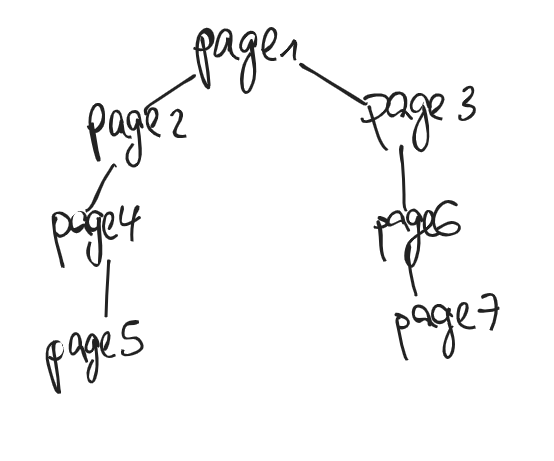

Then, if we call `get_pages_depth()` at `page_1` with `depth = 2`, then it should retrieve the pages `page_1`, `page_2`, `page_4`, `page_3` and `page_6`. We won't care about the order in which these pages are retrieved.

- Implement the function as a generator.

- Remember that a page might contain a link to a parent page, so try to take that into account.

- Consider any other edge cases that might happen, such as two pages leading to the same page. In that case, that page should only be retrieved once.

- Maybe you can add a decorator to handle such cases?

In [84]:
import requests
from urllib.parse import urljoin, urldefrag
from bs4 import BeautifulSoup
from collections import deque

def get_all_links(url: str):
    """
    Get all the links in the webpage at the given URL.

    :param url: A string that is the URL of the webpage where we need to find the links.
    :return: A list with all the links of the given webpage.
    """
    try:
        response = requests.get(url, timeout=1)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error fetching the URL: {e}")
        return []

    soup = BeautifulSoup(response.text, 'html.parser')
    links = [urldefrag(urljoin(url, a.get('href'))).url for a in soup.find_all('a', href=True)]
    return links

def get_pages_depth(url: str, depth: int, links_limit = 20):
    """
    Traverse the web pages starting from the given URL up to the specified depth
    and yield the URLs of the pages encountered.

    :param url: A string that is the URL of the starting webpage.
    :param depth: An integer that specifies the depth of traversal.
    :yield: The URLs of the pages encountered during traversal.
    """
    queue = deque([(url, 0)])  # (url, current_depth)
    visited = set()

    while queue:
        current_url, current_depth = queue.popleft()

        if current_url in visited or current_depth > depth:
            continue

        visited.add(current_url)
        yield (current_url, current_depth)

        if current_depth <= depth:
            links = get_all_links(current_url)[:links_limit]
            for link in links:
                if link not in visited:
                    queue.append((link, current_depth + 1))

In [85]:
for page_url in get_pages_depth('https://en.wikipedia.org/wiki/King_Philip%27s_War', 3, 20):
    print(page_url)

('https://en.wikipedia.org/wiki/King_Philip%27s_War', 0)
('https://en.wikipedia.org/wiki/Main_Page', 1)
('https://en.wikipedia.org/wiki/Wikipedia:Contents', 1)
('https://en.wikipedia.org/wiki/Portal:Current_events', 1)
('https://en.wikipedia.org/wiki/Special:Random', 1)
('https://en.wikipedia.org/wiki/Wikipedia:About', 1)
('https://en.wikipedia.org/wiki/Wikipedia:Contact_us', 1)
('https://en.wikipedia.org/wiki/Help:Contents', 1)
('https://en.wikipedia.org/wiki/Help:Introduction', 1)
('https://en.wikipedia.org/wiki/Wikipedia:Community_portal', 1)
('https://en.wikipedia.org/wiki/Special:RecentChanges', 1)
('https://en.wikipedia.org/wiki/Wikipedia:File_upload_wizard', 1)
('https://en.wikipedia.org/wiki/Special:Search', 1)
('https://donate.wikimedia.org/?wmf_source=donate&wmf_medium=sidebar&wmf_campaign=en.wikipedia.org&uselang=en', 1)
('https://en.wikipedia.org/w/index.php?title=Special:CreateAccount&returnto=King+Philip%27s+War', 1)
('https://en.wikipedia.org/w/index.php?title=Special:Us

## Task 4

Create a class `ComputerScientist` that will contain information such as `name`, `birthdate`, `major_achievements`, `alma_mater`, etc.

- Implement the methods you consider appropriate.

- Make unit tests to make sure the methods work alright.

Write a script to go to this [list of computer scientists](https://en.wikipedia.org/wiki/List_of_computer_scientists) and fetch information about 100 random scientists from this list, and create a python `list` containing `ComputerScientist()` objects with the information retrieved from the given link.

In [152]:
class ComputerScientist:
    def __init__(self, name, birthdate=None, major_achievements=None, alma_mater=None):
        self.name = name
        self.birthdate = birthdate
        self.major_achievements = major_achievements
        self.alma_mater = alma_mater

    def __str__(self):
        return (f"Name: {self.name}\n"
                f"Birthdate: {self.birthdate}\n"
                f"Major Achievements: {self.major_achievements}\n"
                f"Alma Mater: {self.alma_mater}\n")

    def add_achievement(self, achievement):
        self.major_achievements.append(achievement)

    def update_alma_mater(self, alma_mater):
        self.alma_mater = alma_mater

In [164]:
import requests
from bs4 import BeautifulSoup
import random
from openai import OpenAI

def fetch_scientists(url, num_scientists=100):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find all <ul> tags that do not have the class "vector-menu-content-list"
    ul_tags = soup.find_all('ul', class_=lambda x: x != 'vector-menu-content-list')
    
    # Extract all <li> tags from the filtered <ul> tags
    scientist_items = []
    for ul in ul_tags:
        scientist_items.extend(ul.find_all('li'))
    
    # Filter out items that do not contain links (likely not scientists)
    # Also, ensure <a> tags do not contain "vector" in their class attribute
    scientist_links = []
    for item in scientist_items:
        a_tag = item.find('a')
        if a_tag and (not a_tag.get('class') or 'vector' not in ' '.join(a_tag.get('class', []))):
            scientist_links.append(a_tag)
    
    # Randomly select 100 scientists
    # selected_scientists = random.sample(scientist_links, min(num_scientists, len(scientist_links)))
    selected_scientists = scientist_links[:num_scientists]
    print(scientist_links)
    
    scientists = []
    for scientist in selected_scientists:
        name = scientist.get_text()
        href = scientist.get('href')
        if href:
            # Fetch details from the individual scientist's page
            details = fetch_scientist_details("https://en.wikipedia.org" + href)
            scientists.append(ComputerScientist(
                name=name,
                birthdate=details.get('birthdate'),
                major_achievements=details.get('major_achievements'),
                alma_mater=details.get('alma_mater')
            ))
    
    return scientists


def fetch_scientist_details(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    details = {
        'birthdate': None,
        'major_achievements': None,
        'alma_mater': None
    }
    
    # Extract birthdate from the infobox
    infobox = soup.find('table', class_='infobox')
    if not infobox:
        return details
    birthdate_row = infobox.find('th', string='Born')
    if birthdate_row:
        details['birthdate'] = birthdate_row.find_next_sibling('td').get_text(strip=True)
    
    # Extract alma mater from the infobox
    alma_mater_row = infobox.find('th', string='Alma Mater')
    if not alma_mater_row:
        alma_mater_row = infobox.find('th', string='Institutions')
    if alma_mater_row:
        details['alma_mater'] = alma_mater_row.find_next_sibling('td').get_text(strip=True)
    
    # Extract major achievements (this is more heuristic)
    major_achievements_row = infobox.find('th', string='Known for')
    if major_achievements_row:
        details['major_achievements'] = major_achievements_row.find_next_sibling('td').get_text(strip=True)
    
    # print(infobox)
    
    return details


In [155]:
url = "https://en.wikipedia.org/wiki/List_of_computer_scientists"
scientists = fetch_scientists(url, 2)
for scientist in scientists:
    print(scientist)

[<a href="/wiki/Wil_van_der_Aalst" title="Wil van der Aalst">Wil van der Aalst</a>, <a href="/wiki/Scott_Aaronson" title="Scott Aaronson">Scott Aaronson</a>, <a href="/wiki/Rediet_Abebe" title="Rediet Abebe">Rediet Abebe</a>, <a href="/wiki/Hal_Abelson" title="Hal Abelson">Hal Abelson</a>, <a href="/wiki/Serge_Abiteboul" title="Serge Abiteboul">Serge Abiteboul</a>, <a href="/wiki/Samson_Abramsky" title="Samson Abramsky">Samson Abramsky</a>, <a href="/wiki/Leonard_Adleman" title="Leonard Adleman">Leonard Adleman</a>, <a href="/wiki/Manindra_Agrawal" title="Manindra Agrawal">Manindra Agrawal</a>, <a href="/wiki/Luis_von_Ahn" title="Luis von Ahn">Luis von Ahn</a>, <a href="/wiki/Alfred_Aho" title="Alfred Aho">Alfred Aho</a>, <a class="mw-redirect" href="/wiki/Frances_E._Allen" title="Frances E. Allen">Frances E. Allen</a>, <a href="/wiki/Gene_Amdahl" title="Gene Amdahl">Gene Amdahl</a>, <a href="/wiki/David_P._Anderson" title="David P. Anderson">David P. Anderson</a>, <a href="/wiki/Lisa_

/var/folders/6n/ncg6qgv97_ggb605s3fvy7k00000gn/T/ipykernel_30222/2221034909.py:62: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  birthdate_row = infobox.find('th', text='Born')
/var/folders/6n/ncg6qgv97_ggb605s3fvy7k00000gn/T/ipykernel_30222/2221034909.py:67: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  alma_mater_row = infobox.find('th', text='Alma Mater')
/var/folders/6n/ncg6qgv97_ggb605s3fvy7k00000gn/T/ipykernel_30222/2221034909.py:69: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  alma_mater_row = infobox.find('th', text='Institutions')
/var/folders/6n/ncg6qgv97_ggb605s3fvy7k00000gn/T/ipykernel_30222/2221034909.py:74: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  major_achievements_row = infobox.find('th', text='Known for')


Name: Wil van der Aalst
Birthdate: (1966-01-29)29 January 1966(age 59)Eersel,North Brabant
Major Achievements: Workflow patterns, ProM framework,YAWL, software tools such as Declare, Woflan, XRL,
Alma Mater: RWTH Aachen University

Name: Scott Aaronson
Birthdate: Scott Joel Aaronson(1981-05-21)May 21, 1981(age 43)[1][2]Philadelphia,Pennsylvania,United States
Major Achievements: Quantum Turing machine with postselectionAlgebrizationBoson sampling
Alma Mater: University of Texas at AustinMassachusetts Institute of TechnologyInstitute for Advanced StudyUniversity of Waterloo



# Task 5

Use the previously defined `ComputerScientist` class.

Add a new attribute `wikipedia_link` without modifying the definition of the original class. Consider using `setattr()`.

Write a function `fetch_scientist()` that will receive the name of a scientist, and will go to wikipedia and fetch the required scientist, and return a `ComputerScientist` object.

- Remember checking edge cases, such as the scientist not existing.

Add a decorator to cache the request, (i.e: store the answers, and if the scientist was already found before, to not execute the search again).

In [165]:
import requests
from bs4 import BeautifulSoup

def cache_results(func):
    cache = {}

    def wrapper(name):
        # Check if the result is already in the cache
        if name in cache:
            print(f"Fetching '{name}' from cache...")
            return cache[name]
        
        # If not in cache, call the function and store the result
        result = func(name)
        cache[name] = result
        return result

    return wrapper

# Fetch scientist details with caching
@cache_results
def fetch_scientist(name):
    # Construct the Wikipedia search URL
    search_url = f"https://en.wikipedia.org/wiki/{name.replace(' ', '_')}"
    
    # Fetch the page
    response = requests.get(search_url)
    if response.status_code != 200:
        return None  # Scientist not found or other error
    
    # Extract details using the previously defined fetch_scientist_details function
    details = fetch_scientist_details(search_url)
    
    # Create a ComputerScientist object
    scientist = ComputerScientist(
        name=name,
        birthdate=details.get('birthdate'),
        major_achievements=details.get('major_achievements'),
        alma_mater=details.get('alma_mater')
    )
    
    # Add the wikipedia_link attribute using setattr
    setattr(scientist, 'wikipedia_link', search_url)
    
    return scientist

In [167]:
scientist_name = "Alan Turing"
scientist = fetch_scientist(scientist_name)
if scientist:
    print(scientist)
    print(f"Wikipedia Link: {scientist.wikipedia_link}")
else:
    print(f"Scientist '{scientist_name}' not found.")

Fetching 'Alan Turing' from cache...
Name: Alan Turing
Birthdate: Alan Mathison Turing(1912-06-23)23 June 1912Maida Vale, London, England
Major Achievements: Cryptanalysis of the EnigmaTuring's proofTuring machineTuring testunorganised machineTuring patternTuring reduction"The Chemical Basis of Morphogenesis"Turing paradox
Alma Mater: University of ManchesterGovernment Code and Cypher SchoolNational Physical Laboratory

Wikipedia Link: https://en.wikipedia.org/wiki/Alan_Turing


# Task 6**

Consider the directed graph where the nodes represent the wikipedia pages of the scientists and the edges represent whether a scientist's page contains a link to the page of another scientist.

Implement a class named `ScientistGraph`, with some attributes and methods like:
- `scientist_list : list[ComputerScientist]`: the list of all scientists
- `graph`: the graph of scientists connected to other scientists (you can use the graph object from `network`, or implement your own way of storing the graph, for e.g: with an adjacency list or an adjacency matrix).
- `add_scientist(scientist_name: str)`: method that will receive the name of the scientist, fetch the corresponding wikipedia page, create the corresponding `ComputerScientist` object, and will add the new edges involving that scientist to the graph. Consider edge cases like the name being incorrect or the scientist being already stored.
- `remove_scientist(scientist_name: str)`: method that will receive the name of a scientist, remove them from the list and removing its node and the edges involving it from the graph. Consider edge cases like the name being incorrect or the scientist not being stored.
- `plot()`: method that will visualize the graph. Show how the graph changes when adding someone new or deleting someone. Bonus: perhaps you want to implement it in a dynamic way, so each time that a scientist is removed from or added to the graph, the visualization changes.
- `rank_scientists():` method that will rank scientists. For this method you can be as creative as you wish: You can start by designing a ranking based on the number of neighbours of each scientists, or the number of times a scientist is mentioned in one of the articles, or by using the famous `PageRank (you need to google it)`, etc., or by any other methods you might like to consider.

Show the usage of these methods in a proper way.
Feel free to add more functionalities.